# Implementation of FIR Filter in the FPGA

## Generation of the signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import lfilter, firwin #fundamental to simulate a fir_filter in python
import fileinput
import sys

In [2]:
# Let us generate a wave function with two main frequencies, an high one and a low one:

data_size = 125
noise = 1 # the higher the noisier
file = open("../signal.txt", "w") # the file where to write the signal to be filtered

input_sig = []

for i in range(data_size):
    sig = 62*(np.sin(i/(5*np.pi))+ noise)
    noise = -noise
    input_sig.append(sig.astype(int)) # we write it as an int
    file.write(str(sig.astype(int)))
    file.write('\n')

file.close()

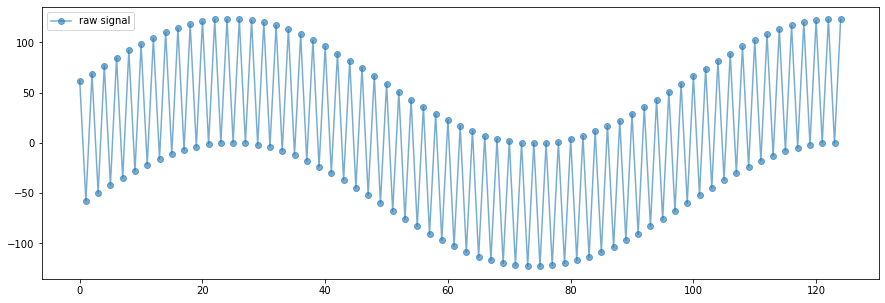

In [3]:
# Now we visualize it:
sig = np.loadtxt("../signal.txt", delimiter='\n')
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

plt.figure(figsize=(15, 5))

plt.plot(t, sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

## Coefficients for the Filter

In [4]:
numtaps = 4 
f = 1

# this function gives us the coefficients used in the testbench
c = signal.firwin(numtaps, f, fs=100)
print("Coefficients for the Fir Filter:", c)

# this function simulates the output of a fir_filter
python_sig = lfilter(c, 1, input_sig)

Coefficients for the Fir Filter: [0.04700274 0.45299726 0.45299726 0.04700274]


## Results

In [5]:
# After being computed on the actual FPGA
##############
code = 'eqs0d'
##############
url = 'https://transfer.sh/'+ code +'/output.txt'

! curl $url --output ../fromfpga.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   372  100   372    0     0   1252      0 --:--:-- --:--:-- --:--:--  1256


In [6]:
fname = "../fromfpga.txt"
fpga = np.loadtxt(fname, delimiter='\n')
for i in range(len(fpga)):
    # 2**10 due to truncation of bits
    # 2**9 because I multiplied the coefficients by 2**9
    fpga[i] = (2**10/2**8)*fpga[i]

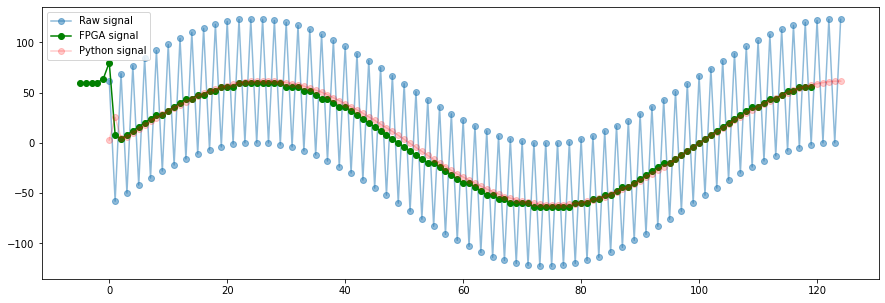

In [7]:
plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.5,label='Raw signal')
plt.plot(t-5, fpga, '-o', color='g',alpha=1,label='FPGA signal')
plt.plot(t, python_sig, '-o', color='r',alpha=.2,label='Python signal')
#plt.title("")
plt.legend(loc="upper left")

## Troubleshooting

In [26]:
# Some functions that may be useful
def sine_wave(A, time, f): # creates a sine wave
    return A * np.sin(2 * np.pi * f * time) # F(t) = A sin(wt) = A sin(2pi f t)

In [27]:
data_size = 125
t = np.linspace(0, 1, data_size) 
print('t =',t[:3],'...',t[data_size-3:])

t = [0.         0.00806452 0.01612903] ... [0.98387097 0.99193548 1.        ]


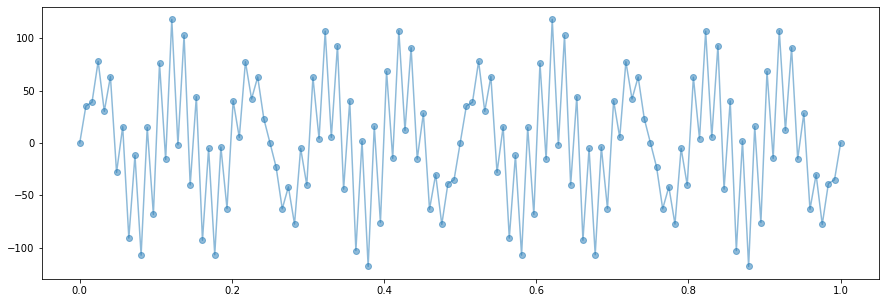

In [54]:
#Now we generate the wave
A1, A2 = 60, 60
f1, f2 = 10, 60

wave = sine_wave(A1, t, f1) + sine_wave(A2, t, f2)

# Let's plot it
plt.figure(figsize=(15, 5))

plt.plot(t, wave, '-o',alpha=.5,label='Raw signal')

In [55]:
numtaps = 4 
f = 3

# this function gives us the coefficients used in the testbench
# numtaps = 4 depends on the structure of the filter (in the weighted sum we add 4 terms)
# f = the cutoff frequency (for a Low-pass from 0 to f)
# fs = The sampling frequency of the signal. 
#      Each frequency in cutoff must be between 0 and fs/2.  (Nyquist theorem)
#      fs is the number of samples obtain in one second
c = signal.firwin(numtaps, f, fs=data_size)
print("Coefficients for the Fir Filter:", c)

coeffpot = 8
rc = c * 2**coeffpot
print(rc)
trunc_rc = np.round(rc,0).astype(int)
bin_rc = []
hex_rc = []

for i in range(numtaps):
    bin_rc.append(bin(trunc_rc[i]))
    hex_rc.append(hex(trunc_rc[i]))
    if len(hex_rc[i]) == 3:
        # this is needed for the vhd code, if the coefficient has only 1 term
        # it will add a 0 before it
        hex_rc[i] = hex_rc[i][:2]+'0'+hex_rc[i][2]
    
print(bin_rc)
print(hex_rc)



Coefficients for the Fir Filter: [0.04673608 0.45326392 0.45326392 0.04673608]
[ 11.964436 116.035564 116.035564  11.964436]
['0b1100', '0b1110100', '0b1110100', '0b1100']
['0x0c', '0x74', '0x74', '0x0c']


In [56]:
# This automatically updates the testbench file for the current coefficients

tap = 0
str1 = 'signal tb_coeff_'
str2 = ': std_logic_vector(7 downto 0) := X"'
str3 = '";  -- [in]'

# This will basically edit the VHD code where we need to change the coefficients
for line in fileinput.input(files ='../testbench/fir_filter_tb.vhd',inplace=True):
    if line.startswith("signal tb_coeff_"):
        print(str1+str(tap)+str2+str(hex_rc[tap][2:])+str3)
        tap = tap + 1
    else:
        sys.stdout.write(line)

In [57]:
filein  = '../testbench/input_vectors.txt'
fileout = '../testbench/output_results.txt'

np.savetxt(filein, wave, fmt='%d', delimiter='\n')

# Compiling the two files
! cd ../testbench; ghdl -a fir_filter.vhd; ghdl -a fir_filter_tb.vhd

# Running the entity
! cd ../testbench; ghdl -r fir_filter_4_tb

# After running the entity, the output of the signal is saved in a .txt file
testbench = np.loadtxt(fileout, delimiter='\n')

! cd ../testbench; rm work-obj93.cf

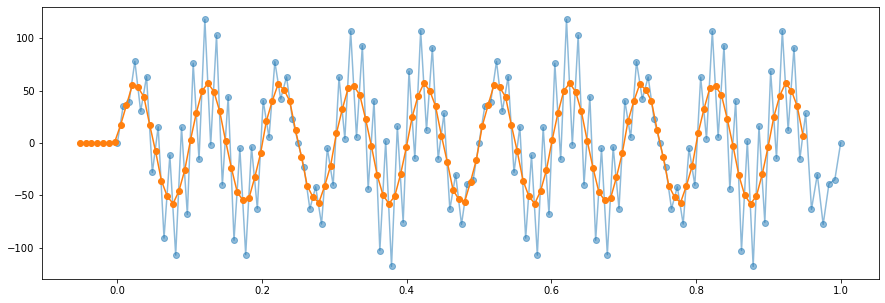

In [58]:
# Let's plot it
plt.figure(figsize=(15, 5))

plt.plot(t, wave, '-o',alpha=.5,label='Raw signal')
plt.plot(t-6.5/data_size, testbench, '-o',alpha=1,label='Filtered signal')